In [1]:
pip install -r https://raw.githubusercontent.com/rizki96/ds_challenge/master/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import bz2
import pandas as pd
import numpy as np
import geohash
import time
import datetime
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests
from math import ceil
from math import sin, cos, sqrt, atan2, radians
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
from collections import OrderedDict
from itertools import islice
from keras.models import load_model

register_matplotlib_converters()

Using TensorFlow backend.


In [3]:
# from local data file
trf_df = pd.read_csv('training.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"')
trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

# from remote data file
#url="https://github.com/rizki96/ds_challenge/blob/master/Traffic%20Management/training.csv.bz2?raw=true"
#s=requests.get(url).content
#data = bz2.decompress(s)
#trf_df = pd.read_csv(io.BytesIO(data), header=0, sep=',', quotechar='"')
#trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

In [4]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand
2289,qp09sx,1,0:0,0.021212
3149,qp0dhg,1,0:0,0.013217
11052,qp03x5,1,0:0,0.157956
23011,qp09bw,1,0:0,0.001262
26180,qp03wn,1,0:0,0.032721


In [5]:
trf_df_sort["dts_cal"] = [datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f') + datetime.timedelta(days=day, hours=int(timestamp.split(":")[0]), minutes=int(timestamp.split(":")[1])) for day,timestamp in trf_df_sort[["day", "timestamp"]].values]

In [6]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal
2289,qp09sx,1,0:0,0.021212,2019-04-01
3149,qp0dhg,1,0:0,0.013217,2019-04-01
11052,qp03x5,1,0:0,0.157956,2019-04-01
23011,qp09bw,1,0:0,0.001262,2019-04-01
26180,qp03wn,1,0:0,0.032721,2019-04-01


# convert geohash into latitude longitude

In [7]:
trf_df_sort.loc[:, 'latlon'] = trf_df_sort.geohash6.map(lambda x: geohash.decode(x))
trf_df_sort['lat'] = [ll[0][0] for ll in trf_df_sort[['latlon']].values]
trf_df_sort['lon'] = [ll[0][1] for ll in trf_df_sort[['latlon']].values]

In [8]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# weeks data

In [9]:
initial_day = 15 # change this to make a moving window
num_of_days = 28
end_day = initial_day + num_of_days
range_btwn_pts = 1 # in km
min_samples = 1
# get the entire data from day 1 to end_day
trf_week1 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= 1) & (trf_df_sort.day < end_day)])

In [10]:
trf_week1[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
4179434,qp0987,42,9:45,0.946659,2019-05-12 09:45:00,"(-5.34210205078125, 90.7196044921875)",-5.342102,90.719604
4181024,qp08fx,42,9:45,0.035368,2019-05-12 09:45:00,"(-5.45196533203125, 90.8184814453125)",-5.451965,90.818481
4194182,qp09ub,42,9:45,0.004904,2019-05-12 09:45:00,"(-5.31463623046875, 90.9173583984375)",-5.314636,90.917358
4194776,qp09ve,42,9:45,0.021424,2019-05-12 09:45:00,"(-5.29815673828125, 90.9503173828125)",-5.298157,90.950317
4204552,qp09k8,42,9:45,0.050238,2019-05-12 09:45:00,"(-5.40252685546875, 90.9063720703125)",-5.402527,90.906372


# initial day to end day cluster

In [11]:
day_ids = list(range(initial_day,end_day)) # generate day_id from initial day to end day
trf_day1 = pd.DataFrame(trf_week1[trf_week1.day.isin(day_ids)])
latlon = trf_day1.groupby('geohash6')['geohash6'].unique().apply(lambda x: geohash.decode(x[0]))
coords = np.array([idx for idx in latlon])
#coords = trf_day1[['lat', 'lon']].values

In [12]:
start_time = time.time()
kms_per_radian = 6371.0088
epsilon = range_btwn_pts / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
# mark as -1 for outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters) if coords[cluster_labels == n].any()])
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if coords[cluster_labels == n].any()])
#num_clusters = len(clusters)
elapsed_time = time.time() - start_time
print('Time taken to cluster: {} secs'.format(elapsed_time))
print('Number of day {} to day {} clusters: {}'.format(day_ids[0], day_ids[-1], num_clusters))
clusters

Time taken to cluster: 0.043138742446899414 secs
Number of day 15 to day 42 clusters: 78


0     [[-5.48492431640625, 90.6536865234375], [-5.47...
1     [[-5.46295166015625, 90.6536865234375], [-5.45...
2     [[-5.48492431640625, 90.6646728515625], [-5.47...
3     [[-5.48492431640625, 90.6756591796875], [-5.47...
4     [[-5.48492431640625, 90.6866455078125], [-5.47...
5     [[-5.48492431640625, 90.6976318359375], [-5.47...
6     [[-5.41351318359375, 90.5877685546875], [-5.40...
7     [[-5.41351318359375, 90.5987548828125], [-5.40...
8     [[-5.41351318359375, 90.6097412109375], [-5.40...
9               [[-5.43548583984375, 90.6427001953125]]
10              [[-5.43548583984375, 90.6536865234375]]
11    [[-5.41351318359375, 90.6207275390625], [-5.40...
12    [[-5.41351318359375, 90.6317138671875], [-5.40...
13    [[-5.41351318359375, 90.6427001953125], [-5.40...
14    [[-5.41351318359375, 90.6536865234375], [-5.40...
15    [[-5.41900634765625, 90.6646728515625], [-5.41...
16    [[-5.30914306640625, 90.5987548828125], [-5.30...
17    [[-5.48492431640625, 90.7086181640625], [-

# cluster centermost_points

In [13]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0     (-5.48492431640625, 90.6536865234375)
1     (-5.45745849609375, 90.6536865234375)
2     (-5.45745849609375, 90.6646728515625)
3     (-5.36407470703125, 90.6756591796875)
4     (-5.36407470703125, 90.6866455078125)
5     (-5.36407470703125, 90.6976318359375)
6     (-5.36407470703125, 90.5877685546875)
7     (-5.36956787109375, 90.5987548828125)
8     (-5.35858154296875, 90.6097412109375)
9     (-5.43548583984375, 90.6427001953125)
10    (-5.43548583984375, 90.6536865234375)
11    (-5.35308837890625, 90.6207275390625)
12    (-5.34210205078125, 90.6317138671875)
13    (-5.32562255859375, 90.6427001953125)
14    (-5.32562255859375, 90.6536865234375)
15    (-5.32562255859375, 90.6646728515625)
16    (-5.30914306640625, 90.5987548828125)
17    (-5.36407470703125, 90.7086181640625)
18    (-5.35858154296875, 90.7196044921875)
19    (-5.40802001953125, 90.7305908203125)
20    (-5.45745849609375, 90.7415771484375)
21    (-5.46295166015625, 90.7525634765625)
22    (-5.46844482421875, 90.763

In [14]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [15]:
rs = rep_points.apply(lambda row: trf_day1[(trf_day1['lat']==row['lat']) & (trf_day1['lon']==row['lon'])].iloc[0], axis=1)
rs[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
73,qp0d0t,15,0:0,0.011592,2019-04-15 00:00:00,"(-5.24322509765625, 90.7305908203125)",-5.243225,90.730591
74,qp0d44,28,9:45,0.003524,2019-04-28 09:45:00,"(-5.25970458984375, 90.7965087890625)",-5.259705,90.796509
75,qp0d4j,17,10:30,0.003967,2019-04-17 10:30:00,"(-5.24322509765625, 90.7965087890625)",-5.243225,90.796509
76,qp0d4m,42,12:15,0.001808,2019-05-12 12:15:00,"(-5.24322509765625, 90.8074951171875)",-5.243225,90.807495
77,qp0d5t,15,10:0,0.002599,2019-04-15 10:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427


# cluster member and centermost_point visualization

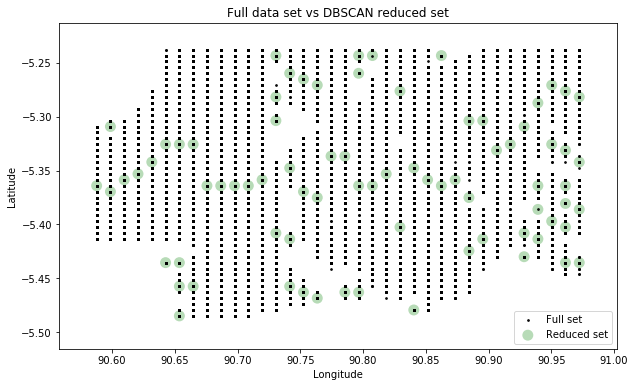

In [16]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(trf_day1['lon'], trf_day1['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='lower right')
plt.show()

# set label and is_centroid to cluster

In [17]:
# map latlon clusters to geohash clusters
latlon_maps = {tuple(g): idx for idx,c in enumerate(clusters) for g in clusters[idx]}

# cluster_labels
trf_day1['cluster_ids'] = [latlon_maps[t] for t in trf_day1['latlon']]

In [18]:
trf_day1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids
9795,qp03pd,15,0:0,0.121186,2019-04-15,"(-5.43548583984375, 90.6866455078125)",-5.435486,90.686646,4
16437,qp03qs,15,0:0,0.219116,2019-04-15,"(-5.38055419921875, 90.6427001953125)",-5.380554,90.642700,13
17465,qp03wg,15,0:0,1.000000,2019-04-15,"(-5.34210205078125, 90.6536865234375)",-5.342102,90.653687,14
28321,qp09vr,15,0:0,0.038991,2019-04-15,"(-5.27618408203125, 90.9393310546875)",-5.276184,90.939331,68
34210,qp06p3,15,0:0,0.016545,2019-04-15,"(-5.26519775390625, 90.6756591796875)",-5.265198,90.675659,3


In [19]:
trf_day1 = trf_day1.sort_values(by=['cluster_ids', 'dts_cal', 'demand'])
trf_day1['is_centroid'] = [(rs['geohash6'][y] == x) for x,y in trf_day1[['geohash6', 'cluster_ids']].values]

In [20]:
trf_day1[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid
4195955,qp0d5t,41,11:15,0.012208,2019-05-11 11:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True
1398670,qp0d5t,42,0:30,0.003890,2019-05-12 00:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True
3818874,qp0d5t,42,6:45,0.005116,2019-05-12 06:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True
3129872,qp0d5t,42,7:30,0.017862,2019-05-12 07:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True
3080913,qp0d5t,42,12:0,0.001621,2019-05-12 12:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True


# set highest_demand and average demand to cluster

In [21]:
trf_day1_avg_demand = trf_day1.groupby(['cluster_ids','geohash6'])['demand'].apply(lambda x: np.mean(x)).sort_values(ascending=False)
trf_day1['highest_demand'] = [trf_day1_avg_demand[x].index[0] == y for x,y in trf_day1[['cluster_ids', 'geohash6']].values]
trf_day1['avg_demand'] = [trf_day1_avg_demand[x][y] for x,y in trf_day1[['cluster_ids', 'geohash6']].values]

In [22]:
#trf_day1[(trf_day1.highest_demand == True) & (trf_day1.geohash6 == 'qp09jt')][:5]
trf_day1[(trf_day1.highest_demand == True)][-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
4195955,qp0d5t,41,11:15,0.012208,2019-05-11 11:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.006019
1398670,qp0d5t,42,0:30,0.003890,2019-05-12 00:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.006019
3818874,qp0d5t,42,6:45,0.005116,2019-05-12 06:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.006019
3129872,qp0d5t,42,7:30,0.017862,2019-05-12 07:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.006019
3080913,qp0d5t,42,12:0,0.001621,2019-05-12 12:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.006019


# visualize time, center point and highest demand

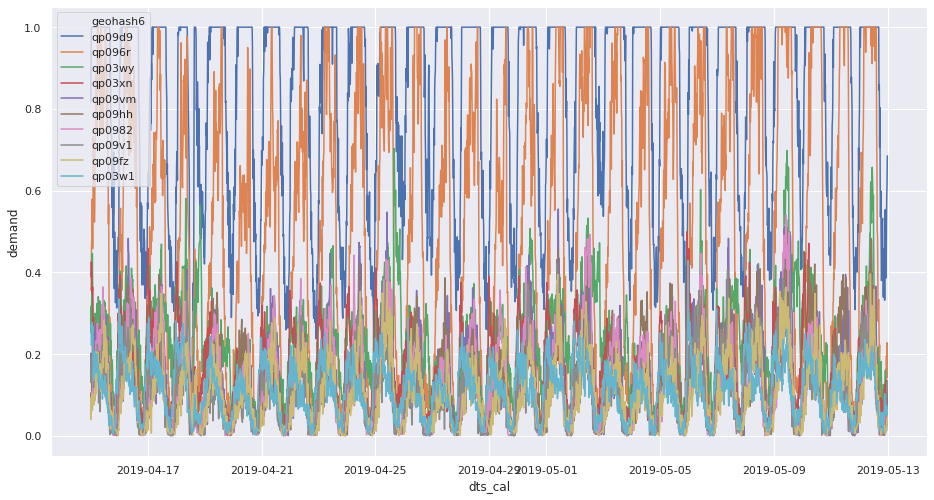

In [23]:
# observation 10 samples cluster's center point demand
trf_day1_center = pd.DataFrame(trf_day1[(trf_day1.is_centroid == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_center[['cluster_ids']].values]))[0:10]
top_trf_day1_center = trf_day1_center[(trf_day1_center.cluster_ids.isin(top_clusters))]
#trf_day1_cl0_others = pd.DataFrame(trf_day1[(trf_day1.is_centroid == False) & (trf_day1.cluster_ids == 0) & (trf_day1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_day1_cl0_others, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_center, legend="full")
plt.show()

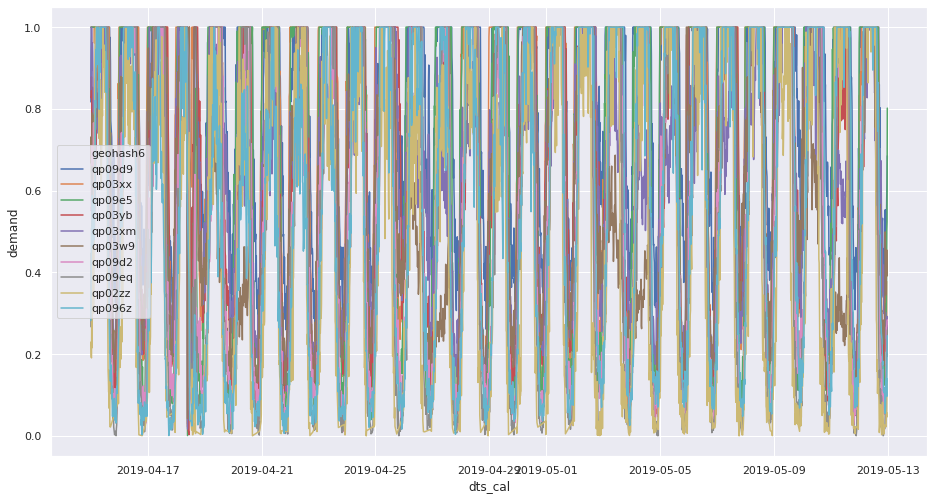

In [24]:
# observation 10 samples cluster's highest demand
trf_day1_highest = pd.DataFrame(trf_day1[(trf_day1.highest_demand == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))[0:10]
top_trf_day1_highest = trf_day1_highest[(trf_day1_highest.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_highest, legend="full")
plt.show()

# zero filling timeseries gap for cluster's highest demand

In [25]:
# looking for anomaly, is there any duplicate timeseries data (make sure it's unique)
unique = True
for c in list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values])):
    if not pd.Series(y for x,y in trf_day1_highest[['cluster_ids', 'dts_cal']].values if x == c).is_unique:
        print('timeseries cluster %s is not unique' % (c,))
        unique = False
if unique:
    print('all timeseries clusters are unique')

all timeseries clusters are unique


In [26]:
# reinitial dataframe, fill unset timestamp with zero
multiplier = len(day_ids)
trf_day1_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': [],
                                   'latlon': [],
                                   'lat': [], 'lon': [],
                                   'cluster_ids': [],
                                   'is_centroid': [],
                                   'highest_demand': [],
                                   'avg_demand': []})

# prepare time and date
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*multiplier)]
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')

gh = trf_day1_highest.groupby(['cluster_ids'])['geohash6'].apply(list)
demand = trf_day1_highest.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)
avg_demand = trf_day1_highest.groupby(['cluster_ids'])['avg_demand'].apply(list)
highest_demand = trf_day1_highest.groupby(['cluster_ids'])['highest_demand'].apply(list)
is_centroid = trf_day1_highest.groupby(['cluster_ids'])['is_centroid'].apply(list)
cluster_list = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))

trf_day1_complete['cluster_ids'] = [c for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['geohash6'] = [gh[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in cluster_list]
trf_day1_complete['day'] = [initial_day + int(t/(24*4)) for t in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in cluster_list]
trf_day1_complete['avg_demand'] = [avg_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['highest_demand'] = [highest_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['is_centroid'] = [is_centroid[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in cluster_list]
trf_day1_complete['latlon'] = [geohash.decode(gh[c][0]) for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lat'] = [geohash.decode(gh[c][0])[0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lon'] = [geohash.decode(gh[c][0])[1] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
0,qp09d9,15,0:0,0.817149,2019-04-15 00:00:00,"(-5.35308837890625, 90.8184814453125)",-5.353088,90.818481,26,True,True,0.833835
1,qp03xx,15,0:0,1.000000,2019-04-15 00:00:00,"(-5.32012939453125, 90.6866455078125)",-5.320129,90.686646,4,False,True,0.759360
2,qp09e5,15,0:0,1.000000,2019-04-15 00:00:00,"(-5.34210205078125, 90.8404541015625)",-5.342102,90.840454,30,False,True,0.743740
3,qp03yb,15,0:0,0.827469,2019-04-15 00:00:00,"(-5.31463623046875, 90.6536865234375)",-5.314636,90.653687,14,False,True,0.696129
4,qp03xm,15,0:0,0.847317,2019-04-15 00:00:00,"(-5.33111572265625, 90.6756591796875)",-5.331116,90.675659,3,False,True,0.664264
5,qp03w9,15,0:0,0.667984,2019-04-15 00:00:00,"(-5.35308837890625, 90.6427001953125)",-5.353088,90.642700,13,False,True,0.628242
6,qp09d2,15,0:0,0.558757,2019-04-15 00:00:00,"(-5.35858154296875, 90.8074951171875)",-5.358582,90.807495,25,False,True,0.607948
7,qp09eq,15,0:0,0.267018,2019-04-15 00:00:00,"(-5.32562255859375, 90.8514404296875)",-5.325623,90.851440,29,False,True,0.563995
8,qp02zz,15,0:0,0.229561,2019-04-15 00:00:00,"(-5.45196533203125, 90.6976318359375)",-5.451965,90.697632,5,False,True,0.558352
9,qp096z,15,0:0,0.282191,2019-04-15 00:00:00,"(-5.36407470703125, 90.8294677734375)",-5.364075,90.829468,27,False,True,0.558064


# visualize after zero fill gap

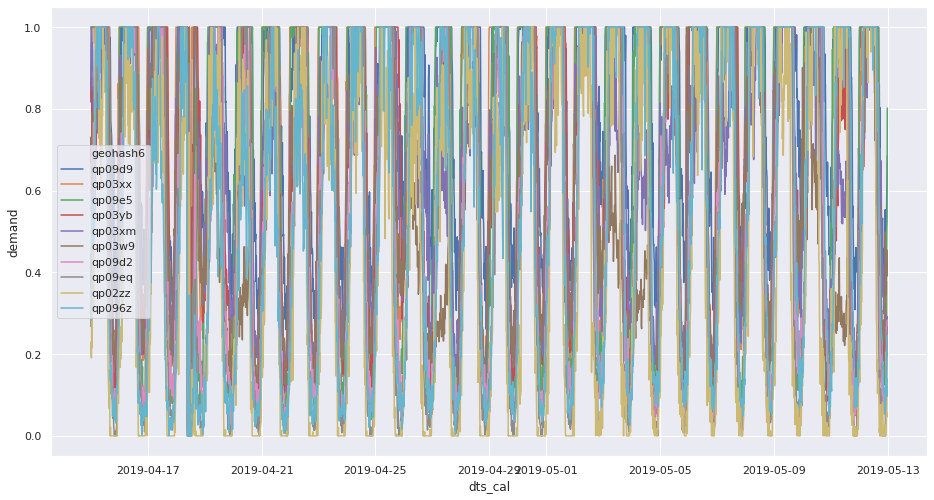

In [27]:
# observation 10 samples cluster's highest demand
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_complete[['cluster_ids']].values]))[0:10]
top_trf_day1_complete_highest = trf_day1_complete[(trf_day1_complete.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_complete_highest, legend="full")
plt.show()

# timeseries prediction

In [28]:
# prepare sorted data
total_sequence_series = 24*4*multiplier # 15 minutes within 24*multiplier hours
#past_length = int(((multiplier-1) / multiplier)*total_sequence_series)
prediction_length = int(24*4*(multiplier/2))
trf_day1_complete_sort = trf_day1_complete.sort_values(by=['cluster_ids','dts_cal'], ascending=True)
print("total_sequence_series: %s, prediction_length: %s" % (total_sequence_series, prediction_length))
trf_day1_complete_sort[-5:]

total_sequence_series: 2688, prediction_length: 1344


,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
209348,qp0d5t,42,22:45,0.0,2019-05-12 22:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.006019
209426,qp0d5t,42,23:0,0.0,2019-05-12 23:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.006019
209504,qp0d5t,42,23:15,0.0,2019-05-12 23:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.006019
209582,qp0d5t,42,23:30,0.0,2019-05-12 23:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.006019
209660,qp0d5t,42,23:45,0.0,2019-05-12 23:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.006019


In [29]:
# grouping and prepare prerequisite data
cluster_list = list(set([c for c in trf_day1_complete_sort['cluster_ids']]))
demand = trf_day1_complete_sort.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)

In [30]:
# weekly prediction using keras
from lib import keras_timeseries

# setup train and test data for keras
train_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[:-prediction_length]] for c in cluster_list]
test_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[total_sequence_series-prediction_length:]] for c in cluster_list]

X_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in train_day1_ds]))
X_data = X_mat.round(15).reshape(len(cluster_list), total_sequence_series-prediction_length, 1)
y_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in test_day1_ds]))
y_data = y_mat.round(15).reshape(len(cluster_list), prediction_length, 1)

test_count = int(0.5*X_data.shape[0])
test_count = test_count if test_count < 32 else 32*ceil(test_count / 32)
X_train = X_data[:-(X_data.shape[0]-test_count)]
X_test = X_data[X_data.shape[0]-test_count:]

#print(X_train.shape, X_test.shape)

y_train = y_data[:-(y_data.shape[0]-test_count)]
y_test = y_data[y_data.shape[0]-test_count:]

#print(y_train.shape, y_test.shape)

N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
train_batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 24 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series
test_batch_size = X_test.shape[0]

inputs, outputs = \
    [keras_timeseries.stateful_cut(arr, train_batch_size, T_after_cut) for arr in \
    [X_train, y_train]]
inputs_test, outputs_test = \
    [keras_timeseries.stateful_cut(arr, test_batch_size, T_after_cut) for arr in \
    [X_test, y_test]]
#inputs, outputs, inputs_test, outputs_testtest_count = test_count if test_count < 32 else 32*ceil(test_count / 32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3584 samples, validate on 3584 samples
Epoch 1/500
3584/3584 [==============================] - 1s 355us/step - loss: 0.2414 - val_loss: 0.1551
Epoch 2/500
3584/3584 [==============================] - 1s 217us/step - loss: 0.1844 - val_loss: 0.1267
Epoch 3/500
3584/3584 [==============================] - 1s 217us/step - loss: 0.1526 - val_loss: 0.1092
Epoch 4/500
3584/3584 [==============================] - 1s 219us/step - loss: 0.1318 - val_loss: 0.0969
Epoch 5/500
3584/3584 [==============================] - 1s 209us/step - loss: 0.1171 - val_loss: 0.0879
Epoch 6/500
3584/3584 [==============================] - 1s 212us/step - loss: 0.1066 - val_loss: 0.0812
Epoch 7/500
3584/3584 [==============================] - 1s 213us/step - loss: 0.0984 - val_loss: 0.0758
Epoch 8/500
3584/3584 [==============================] - 1s 214us/step - loss: 0.0915 - val_loss:

3584/3584 [==============================] - 1s 207us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 73/500
3584/3584 [==============================] - 1s 208us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 74/500
3584/3584 [==============================] - 1s 199us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 75/500
3584/3584 [==============================] - 1s 210us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 76/500
3584/3584 [==============================] - 1s 224us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 77/500
3584/3584 [==============================] - 1s 202us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 78/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 79/500
3584/3584 [==============================] - 1s 198us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 80/500
3584/3584 [==============================] - 1s 216us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 81/500
3584/3584 [==============================] - 1

Epoch 149/500
3584/3584 [==============================] - 1s 233us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 150/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 151/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 152/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 153/500
3584/3584 [==============================] - 1s 208us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 154/500
3584/3584 [==============================] - 1s 201us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 155/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 156/500
3584/3584 [==============================] - 1s 219us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 157/500
3584/3584 [==============================] - 1s 213us/step - loss: 0.0075 - val_loss: 0.0064
Epoch 158/500
3584/3584 [============

3584/3584 [==============================] - 1s 201us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 226/500
3584/3584 [==============================] - 1s 214us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 227/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 228/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 229/500
3584/3584 [==============================] - 1s 230us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 230/500
3584/3584 [==============================] - 1s 200us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 231/500
3584/3584 [==============================] - 1s 199us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 232/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 233/500
3584/3584 [==============================] - 1s 208us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 234/500
3584/3584 [==========================

3584/3584 [==============================] - 1s 217us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 302/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 303/500
3584/3584 [==============================] - 1s 210us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 304/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 305/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 306/500
3584/3584 [==============================] - 1s 208us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 307/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 308/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 309/500
3584/3584 [==============================] - 1s 214us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 310/500
3584/3584 [==========================

3584/3584 [==============================] - 1s 208us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 378/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 379/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 380/500
3584/3584 [==============================] - 1s 224us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 381/500
3584/3584 [==============================] - 1s 210us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 382/500
3584/3584 [==============================] - 1s 199us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 383/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 384/500
3584/3584 [==============================] - 1s 214us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 385/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 386/500
3584/3584 [==========================

3584/3584 [==============================] - 1s 223us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 454/500
3584/3584 [==============================] - 1s 209us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 455/500
3584/3584 [==============================] - 1s 197us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 456/500
3584/3584 [==============================] - 1s 210us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 457/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 458/500
3584/3584 [==============================] - 1s 202us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 459/500
3584/3584 [==============================] - 1s 230us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 460/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 461/500
3584/3584 [==============================] - 1s 200us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 462/500
3584/3584 [==========================

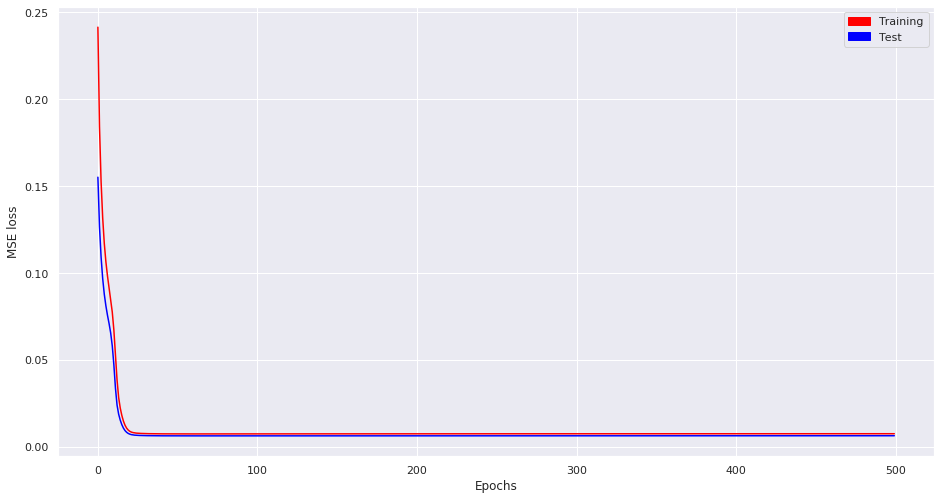

In [31]:
# building network and training
model = keras_timeseries.build_model(train_batch_size, int(total_sequence_series/T), dim_in, dim_out, T_after_cut)
epochs = 500
history = keras_timeseries.train_model(model, inputs, outputs, inputs_test, outputs_test,
                N, T, epochs, train_batch_size, test_batch_size, T_after_cut)
keras_timeseries.plotting(history)

# saving the model
model_path = 'model/keras-epoch%s-stateful-init%s-%sdays.lstm' % (epochs, initial_day, len(day_ids))
model.save(model_path)

In [32]:
# predicting and evaluating
model = load_model(model_path)

interval=64
first_idx = range(0, interval)
second_idx = range(len(cluster_list)-interval, len(cluster_list))

first_x = X_data[first_idx]
first_y = y_data[first_idx]
first_yhat = model.predict(first_x, batch_size=interval)

second_x = X_data[second_idx]
second_y = y_data[second_idx]
second_yhat = model.predict(second_x, batch_size=interval)

actual_x = [first_x[c] for c in first_idx]
actual_x.extend([second_x[c] for c in range(interval-(len(cluster_list)-interval), interval)])
actual_y = [first_y[c] for c in first_idx]
actual_y.extend([second_y[c] for c in range(interval-(len(cluster_list)-interval), interval)])
predicted_y = [first_yhat[c] for c in first_idx]
predicted_y.extend([second_yhat[c] for c in range(interval-(len(cluster_list)-interval), interval)])

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'cluster_ids': [],
    'ts': []})

actual_x_df = pd.DataFrame([actual_x[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
actual_y_df = pd.DataFrame([actual_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
predicted_x_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in cluster_list])
predicted_y_df = pd.DataFrame([predicted_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])

result_df['cluster_ids'] = [c for _ in interval_time for c in cluster_list]
result_df['ts'] = [start_date + t for t in interval_time for _ in cluster_list]
actual_result = actual_x_df.append(actual_y_df)
predicted_result = predicted_x_df.append(predicted_y_df)
result_df = result_df.sort_values(['ts', 'cluster_ids'])
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

#result_df[result_df.cluster_ids == 0]
top_result_df = result_df[result_df.cluster_ids.isin(top_clusters)]

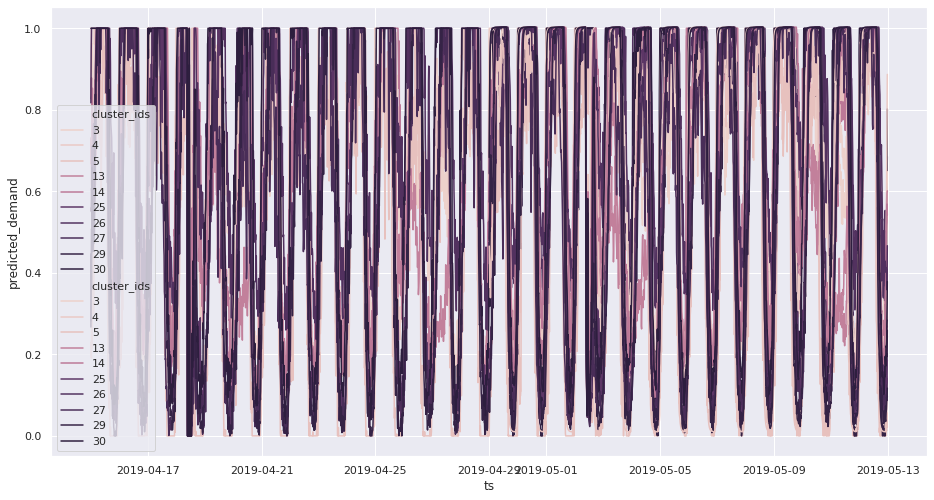

In [33]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="ts", y="actual_demand", hue="cluster_ids", ax=ax, data=top_result_df, legend="full")
ax = sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", ax=ax, data=top_result_df, legend="full")

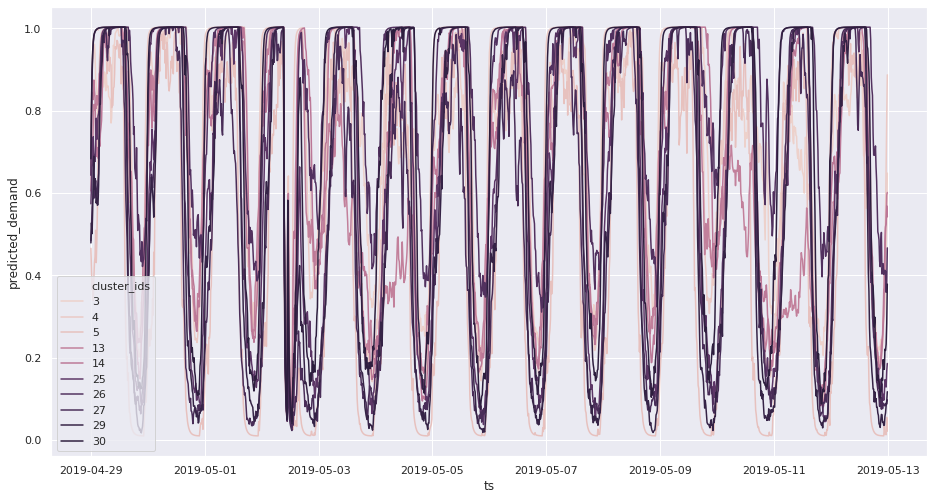

In [34]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", data=top_result_df, legend="full")
plt.show()

# find predicted demand of a geohash point by datetime

In [35]:
def measure_distance(x1, y1, x2, y2):
    R = 6373.0

    lat1 = radians(x1)
    lon1 = radians(y1)
    lat2 = radians(x2)
    lon2 = radians(y2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [36]:
trf_day1[(trf_day1.is_centroid == False) & (trf_day1.highest_demand == False)].sort_values(['dts_cal'])

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
1839218,qp06p9,15,0:0,0.000439,2019-04-15 00:00:00,"(-5.26519775390625, 90.6866455078125)",-5.265198,90.686646,4,False,False,0.014219
3574392,qp09s3,15,0:0,0.000559,2019-04-15 00:00:00,"(-5.35308837890625, 90.8953857421875)",-5.353088,90.895386,57,False,False,0.020150
2910002,qp09u7,15,0:0,0.002041,2019-04-15 00:00:00,"(-5.29815673828125, 90.8953857421875)",-5.298157,90.895386,57,False,False,0.046352
1850053,qp09u3,15,0:0,0.005673,2019-04-15 00:00:00,"(-5.30914306640625, 90.8953857421875)",-5.309143,90.895386,57,False,False,0.031504
3177359,qp09s2,15,0:0,0.011253,2019-04-15 00:00:00,"(-5.35858154296875, 90.8953857421875)",-5.358582,90.895386,57,False,False,0.017287
2809511,qp0dhk,15,0:0,0.014940,2019-04-15 00:00:00,"(-5.24871826171875, 90.8953857421875)",-5.248718,90.895386,57,False,False,0.029954
762239,qp0dhq,15,0:0,0.016387,2019-04-15 00:00:00,"(-5.23773193359375, 90.8953857421875)",-5.237732,90.895386,57,False,False,0.016639
2455579,qp09u2,15,0:0,0.028691,2019-04-15 00:00:00,"(-5.31463623046875, 90.8953857421875)",-5.314636,90.895386,57,False,False,0.035701
1798070,qp09sq,15,0:0,0.030352,2019-04-15 00:00:00,"(-5.32562255859375, 90.8953857421875)",-5.325623,90.895386,57,False,False,0.057105
1413884,qp0dh7,15,0:0,0.033834,2019-04-15 00:00:00,"(-5.25421142578125, 90.8953857421875)",-5.254211,90.895386,57,False,False,0.015444


In [37]:
# prepare data day n+(n/2) for evaluation
initial_week3 = day_ids[-1] + 1
num_of_days = int(len(day_ids) / 2)
trf_week3 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_week3) & (trf_df_sort.day < (initial_week3 + num_of_days))])
trf_week3 = trf_week3.sort_values(['geohash6', 'dts_cal'])
geohash_list = list(set([c for c in trf_week3['geohash6']]))

trf_week3_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': []})
interval_time = [datetime.timedelta(days=initial_week3,minutes=15*t) for t in range(24*4*num_of_days)]
gh = trf_week3.groupby(['geohash6', 'dts_cal'])['geohash6'].apply(list)
demand = trf_week3.groupby(['geohash6', 'dts_cal'])['demand'].apply(list)

trf_week3_complete['geohash6'] = [gh[c][0][0] for _ in range(24*4*num_of_days) for c in geohash_list]
trf_week3_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in geohash_list]
trf_week3_complete['day'] = [initial_week3 + int(t/(24*4)) for t in range(24*4*num_of_days) for c in geohash_list]
trf_week3_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in geohash_list]
trf_week3_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in geohash_list]
trf_week3_complete

,geohash6,day,timestamp,demand,dts_cal
0,qp0955,43,0:0,0.000000,2019-05-13 00:00:00
1,qp08by,43,0:0,0.000000,2019-05-13 00:00:00
2,qp03rd,43,0:0,0.008044,2019-05-13 00:00:00
3,qp03rm,43,0:0,0.069260,2019-05-13 00:00:00
4,qp0973,43,0:0,0.000000,2019-05-13 00:00:00
5,qp09jv,43,0:0,0.002472,2019-05-13 00:00:00
6,qp03mk,43,0:0,0.000000,2019-05-13 00:00:00
7,qp03xs,43,0:0,0.159657,2019-05-13 00:00:00
8,qp0d4c,43,0:0,0.026784,2019-05-13 00:00:00
9,qp03m3,43,0:0,0.003169,2019-05-13 00:00:00


In [38]:
# find input point's distance from centermost
input_point = 'qp09ux' # 1 cluster sample
input_point = 'qp096h'
#input_point = 'qp09hm'
latlon = geohash.decode(input_point)
trf_day1_dist = pd.DataFrame(trf_day1)
trf_day1_dist['distance'] = trf_day1_dist.latlon.apply(lambda latlon2: measure_distance(latlon[0], latlon[1], latlon2[0], latlon2[1]))
trf_day1_dist = trf_day1_dist.sort_values(['distance', 'dts_cal'])
search_cluster = trf_day1_dist['cluster_ids'].iloc[0]
data_sample = trf_day1_complete[(trf_day1_complete.cluster_ids == search_cluster) & (trf_day1_complete.highest_demand == True)]
sample_geohash = data_sample['geohash6'].iloc[0]
trf_week3_eval = trf_week3[(trf_week3.geohash6 == sample_geohash)]

interval=64
first_idx = range(0, interval)
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*multiplier)]

X_actual_data = [[[[data_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[:-prediction_length])] for _ in first_idx]]
y_actual_data = [[[[data_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[total_sequence_series-prediction_length:])] for _ in first_idx]]
predicted_actual_data = model.predict(X_actual_data, batch_size=interval)

eval_sample = trf_week3_complete[trf_week3_complete.geohash6 == sample_geohash]
X_eval_data = predicted_actual_data
y_eval_data = [[[[eval_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[:-prediction_length])] for _ in first_idx]]
predicted_eval_data = model.predict(X_eval_data, batch_size=interval)


# actual vs predicted per cluster highest demand

In [39]:
X_actual_df = pd.DataFrame([X_actual_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
y_actual_df = pd.DataFrame([y_actual_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
X_predicted_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in first_idx[:1]])
y_predicted_df = pd.DataFrame([predicted_actual_data[c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])

y_eval_df = pd.DataFrame([y_eval_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
y_predicted_eval_df = pd.DataFrame([predicted_eval_data[c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])

ext_interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*(multiplier+num_of_days))]

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'predicted_50_quant': [],
    'predicted_90_quant': [],
    'ts': []})

result_df['ts'] = [start_date + t for t in ext_interval_time for _ in first_idx[:1]]
#result_df['ts'] = [datetime.datetime.timestamp(start_date + t) for t in ext_interval_time for _ in first_idx[:1]]
#print(len([start_date + t for t in ext_interval_time for _ in first_idx[:1]]))

#rng = pd.date_range('2019-04-01 00:00:00', periods=24*4*(multiplier+num_of_days), freq='15min')
#result_df['ts'] = rng
#result_df.set_index(['ts'])
#result_df.index = pd.to_datetime(result_df.index, unit='s')

actual_result = X_actual_df.append(y_actual_df).append(y_eval_df)
predicted_result = X_predicted_df.append(y_predicted_df).append(y_predicted_eval_df)
result_df = result_df.sort_values(['ts'])
result_df['ts'] = pd.to_datetime(result_df.ts)
result_df.index = pd.DatetimeIndex(result_df.ts)
result_df.set_index('ts')
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

g = result_df.groupby([pd.Grouper(freq='H')])
result_df['predicted_50_quant'] = g.quantile(0.50)['predicted_demand']
result_df['predicted_90_quant'] = g.quantile(0.90)['predicted_demand']

result_df
#melted_df = pd.melt(result_df, id_vars=[], 
#                   value_vars=result_df['ts'],
#                   value_name='predicted_demand',
#                   var_name=['ts'])
#melted_df

,actual_demand,predicted_demand,predicted_50_quant,predicted_90_quant,ts
ts,,,,,
2019-04-15 00:00:00,0.108944,NaN,NaN,NaN,2019-04-15 00:00:00
2019-04-15 00:15:00,0.176271,NaN,NaN,NaN,2019-04-15 00:15:00
2019-04-15 00:30:00,0.167174,NaN,NaN,NaN,2019-04-15 00:30:00
2019-04-15 00:45:00,0.251033,NaN,NaN,NaN,2019-04-15 00:45:00
2019-04-15 01:00:00,0.181634,NaN,NaN,NaN,2019-04-15 01:00:00
2019-04-15 01:15:00,0.238417,NaN,NaN,NaN,2019-04-15 01:15:00
2019-04-15 01:30:00,0.265621,NaN,NaN,NaN,2019-04-15 01:30:00
2019-04-15 01:45:00,0.208515,NaN,NaN,NaN,2019-04-15 01:45:00
2019-04-15 02:00:00,0.211949,NaN,NaN,NaN,2019-04-15 02:00:00


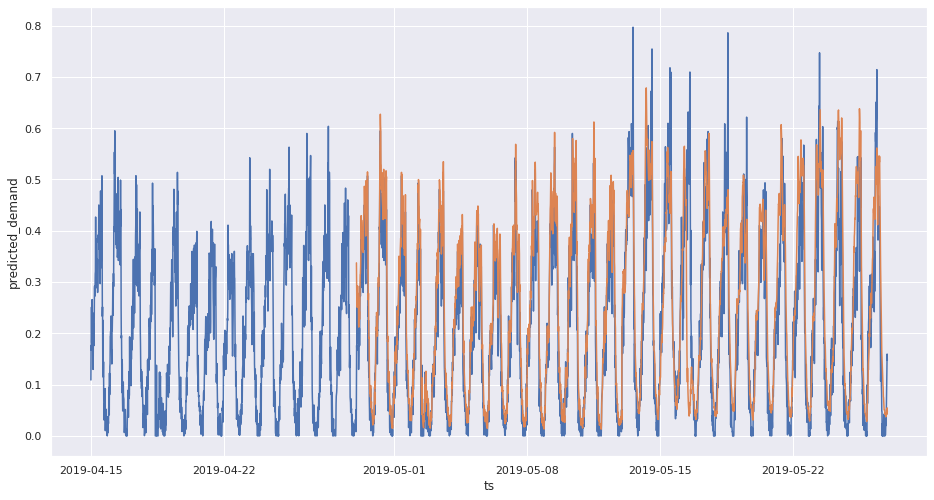

In [42]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="ts", y="actual_demand", data=result_df, ax=ax)
ax = sns.lineplot(x="ts", y="predicted_demand", data=result_df, ci="sd", err_style="band", ax=ax)
#ax = sns.lineplot(x="ts", y="predicted_50_quant", data=result_df, ci=50, ax=ax, legend="full")
#ax = sns.lineplot(x="ts", y="predicted_90_quant", data=result_df, ci=90, ax=ax, legend="full")
#sns.tsplot([result_df.actual_demand, result_df.predicted_demand])